In [2]:
import sim
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
print('Program started')
sim.simxFinish(-1)  # just in case, close all opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected to remote API server')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive. You can guarantee this with (for example):
    sim.simxGetPingTime(clientID)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')
print('Program ended')

Program started
Connected to remote API server
Program ended


In [4]:
# Actuator names
left_motor_name = "Pioneer_p3dx_leftMotor"
right_motor_name = "Pioneer_p3dx_rightMotor"

# Values to send  (rad/sec)
left_velocity = -1.0
right_velocity = 1.0


# Send the command!
print('Program started')
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')

Program started
Connected
Simulation time in milliseconds:  10200
Omnirob is at [x,y,z]= [7.624995231628418, 8.549098014831543, 0.3544987440109253]
Disconnected


In [5]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

In [6]:
# Trajectory functions
def point_to_point_traj(x1, x2, v1, v2, delta_t):
  t = np.linspace(0, delta_t, 100)  
  a0 = x1
  a1 = v1
  a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
  a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

  polynomial = a0 + a1 * t + a2 * t**2 + a3 * t**3
  derivative = a1 + 2*a2 * t + 3 * a3 * t**2
  return polynomial, derivative


def piecewise2D (X,Y, Vx, Vy, T):
    theta_x, theta_y, dx, dy = [], [], [], []

    for i in range(len(P)-1):          
        theta_xi, dxi = point_to_point_traj(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        theta_yi, dyi = point_to_point_traj(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])

        theta_x += theta_xi.tolist()
        theta_y += theta_yi.tolist()
        dx += dxi.tolist()
        dy += dyi.tolist()
        
        plot(theta_xi, theta_yi)
    return theta_x, theta_y, dx, dy

Robot connected
Robot position: (7.62, 8.55) 
Desired position: (0.40, 8.05) 
Relative position: (-7.22, -0.50) 


KeyboardInterrupt: 

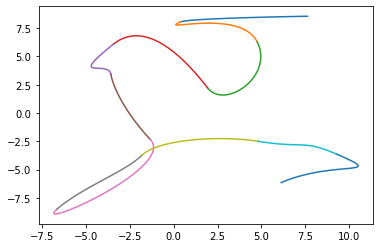

In [17]:
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

# Initial locations
robot_position = r.get_position()
print('Robot position: (%.2f, %.2f) '%(robot_position[0], robot_position[1]))

desired_position = r.get_object_position('Sphere1')
print('Desired position: (%.2f, %.2f) '%(desired_position[0], desired_position[1]))

relative_position = r.get_object_relative_position('Sphere1')
print('Relative position: (%.2f, %.2f) '%(relative_position[0], relative_position[1]))


p1 = robot_position
p2 = r.get_object_position('Sphere1')
p3 = [4.75,6.30,0]
p4 = r.get_object_position('Sphere')
p5 = [-3.45,6.0625,0]
p6 = r.get_object_position('Sphere0')
p7 = [-1.33,-2.35,0]
p8 = r.get_object_position('Sphere4')
p9 = [-1.82,-3.75,0]
p10 =r.get_object_position('Sphere2') 
p11 = [9.3,-3.65,0]
p12 = r.get_object_position('Sphere3')

v1 = [0,0,0]
v2 = [-1.5,-1,0]
v3 = [1,-3,0]
v4 = [-1,2,0]
v5 = [-2,-2.5,0]
v6 = [0.1,-1,0]
v7 = [1.5,-2.5,0]
v8 = [1.5,2,0]
v9 = [1,1.5,0]
v10 =[2,-0.5,0]
v11 = [1.5,-1,0]
v12 = [-1.5,-1,0]

t1 = 0
t2 = 1
t3 = 4
t4 = 7
t5 = 10
t6 = 14
t7 = 17
t8 = 20
t9= 23
t10 = 26
t11 = 30
t12 = 36

# Convert the initial conditions to a vector form
P = np.vstack((p1, p2, p3, p4, p5,p6,p7,p8,p9,p10,p11,p12))
V = np.vstack((v1, v2, v3, v4, v5,v6,v7,v8,v9,v10,v11,v12))
T = [t1, t2, t3, t4, t5,t6,t7,t8,t9,t10,t11,t12]

X, Y = P[:,0], P[:,1]
Vx, Vy = V[:,0], V[:,1]

# Plot the trajectory that passes trhough the desired waypoints
theta_x, theta_y, dx, dy = piecewise2D(X,Y, Vx, Vy, T)

for x, y,dx1,dy1 in zip(theta_x, theta_y, dx, dy):
    point_traj = array([x,y,0])
    vel_traj = array([dx1,dy1,0])
    
    robot_position = r.get_position()
    u = 10 * (point_traj - robot_position) + vel_traj
    
    vx, vy, vz = u
    r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])

    time.sleep((t12)/1000) 
r.send_motor_velocities([0, 0, 0, 0]) 